In [8]:
import pandas as pd
import numpy as np
import pickle
from tabulate import tabulate
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,roc_auc_score, classification_report, 
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import (
    RandomForestClassifier, StackingClassifier, GradientBoostingClassifier, 
    HistGradientBoostingClassifier, AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin

from interpret.glassbox import ExplainableBoostingClassifier 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from ngboost import NGBClassifier
from ngboost.distns import Bernoulli 
from snapml import BoostingMachineClassifier  
from pytorch_tabnet.tab_model import TabNetClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from skorch import NeuralNetClassifier
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tab_transformer_pytorch import TabTransformer 
from tab_transformer_pytorch import FTTransformer

In [9]:
df = pd.read_csv('data/cleaned_data.csv')
cols_to_keep = ['age', 
                'height',
                'weight',
                'systolic', 
                'diastolic',
                'bmi',
                'map',
                'pulse_pressure',
                'gender',
                'cholesterol', 
                'gluc',
                'smoke', 
                'alco', 
                'active',
                'cardio'
                ]

df = df[cols_to_keep]

In [10]:
X = df.drop('cardio', axis=1)
y = df['cardio']

label_mapping = {0: 'Healthy', 1: 'Cardio Risk'}
target_names = [label_mapping[label] for label in y.unique()]

numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 'map', 'pulse_pressure']
ordinal_features = ['cholesterol', 'gluc']
binary_features = ['gender', 'smoke', 'alco', 'active']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Catatan: ColumnTransformer dengan remainder='passthrough' akan mengubah urutan kolom.
# Fitur yang discaling akan berada di awal, kemudian sisanya.
# Untuk mendapatkan nama kolom kembali (opsional), kita bisa menyusun ulang nama kolom sebagai berikut.
passthrough_features = [col for col in X.columns if col not in numerical_features]
transformed_feature_names = numerical_features + passthrough_features

X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_feature_names)
print("Contoh data train setelah scaling:")
print(X_train_transformed_df.head())

Contoh data train setelah scaling:
        age    height    weight  systolic  diastolic       bmi       map  \
0 -0.431181 -0.580958  0.227592 -0.448449  -0.219513  0.556238 -0.357337   
1  1.645896 -0.050963  0.146374 -0.448449  -1.522162  0.164370 -1.087684   
2 -1.766444  0.479031 -0.503370 -1.149304  -1.522162 -0.739102 -1.453955   
3 -1.469719  0.611530  1.933169  1.303690   1.734461  1.485835  1.653859   
4 -0.134455  1.009026  0.146374 -0.448449  -0.219513 -0.388598 -0.357337   

   pulse_pressure  gender  cholesterol  gluc  smoke  alco  active  
0       -0.453476     0.0          0.0   0.0    0.0   0.0     0.0  
1        0.508610     0.0          0.0   0.0    0.0   0.0     0.0  
2       -0.453476     0.0          0.0   0.0    0.0   0.0     1.0  
3        0.508610     1.0          0.0   0.0    1.0   1.0     1.0  
4       -0.453476     0.0          0.0   0.0    0.0   0.0     1.0  


In [11]:
x_train_np = np.array(X_train_transformed)
y_train_np = np.array(y_train)
x_test_np = np.array(X_test_transformed)
y_test_np = np.array(y_test)

In [12]:
class TabularDataset(Dataset):
    def __init__(self, X, categorical_indices, continuous_indices, targets):
        self.X = X
        self.categorical_indices = categorical_indices
        self.continuous_indices = continuous_indices
        self.targets = targets
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        row = self.X[idx]
        x_cont = row[self.continuous_indices].astype(np.float32)
        x_cat  = row[self.categorical_indices].astype(np.int64)
        target = np.array(self.targets[idx]).astype(np.float32)
        return x_cat, x_cont, target

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, epochs=10, lr=1e-3, batch_size=32, device=None,
                continuous_indices=None, categorical_indices=None, classes_=None):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.continuous_indices = continuous_indices
        self.categorical_indices = categorical_indices
        self.classes_ = classes_ if classes_ is not None else []
    
    def fit(self, X, y):
        if self.continuous_indices is None or self.categorical_indices is None:
            raise ValueError("continuous_indices and categorical_indices must be provided")
        train_dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, y)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        self.model.to(self.device)
        self.model.train()
        criterion = torch.nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch in train_loader:
                x_cat, x_cont, targets = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                targets = targets.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(x_cat, x_cont)
                loss = criterion(outputs, targets.float().unsqueeze(1))
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(train_loader)
            print(f"[Wrapper] Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")
        self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        preds = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                preds.append((probs.cpu().numpy() >= 0.5).astype(int))
        preds = np.concatenate(preds).squeeze()
        return preds

    def predict_proba(self, X):
        self.model.eval()
        dummy_targets = np.zeros(len(X))
        dataset = TabularDataset(X, self.categorical_indices, self.continuous_indices, dummy_targets)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)
        probas = []
        with torch.no_grad():
            for batch in loader:
                x_cat, x_cont, _ = batch
                x_cat = x_cat.to(self.device)
                x_cont = x_cont.to(self.device)
                outputs = self.model(x_cat, x_cont)
                probs = torch.sigmoid(outputs)
                probas.append(probs.cpu().numpy())
        probas = np.concatenate(probas).squeeze()
        return np.vstack([1 - probas, probas]).T

    def get_params(self, deep=True):
        return {
            "model": self.model,
            "epochs": self.epochs,
            "lr": self.lr,
            "batch_size": self.batch_size,
            "device": self.device,
            "continuous_indices": self.continuous_indices,
            "categorical_indices": self.categorical_indices,
            "classes_": self.classes_
        }
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [ ]:
def evaluate_model(
    model,
    x_train=None, y_train=None,
    x_test=None,  y_test=None,
    name='Model',
    label_mapping=None,
    cat_indices=None,
    cont_indices=None,
    device='cpu',
    # PyTorch‑specific args:
    train_loader=None,
    test_loader=None,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    comparison_models: dict = None
):
    """
    Universal evaluation for sklearn‑style or a raw PyTorch TabTransformer.
    """
    is_torch_module = isinstance(model, nn.Module) and not hasattr(model, "predict")
    
    # ===== CABANG TORCH MODULE =====
    if is_torch_module:
        # Jika user tidak kirim DataLoader, buat dari raw arrays
        if (x_train is None or y_train is None or
            x_test  is None or y_test  is None):
            raise ValueError("Provide x_train, y_train, x_test, y_test for nn.Module models")

        # Bangun DataLoader
        train_ds = TabularDataset(x_train, cat_indices, cont_indices, y_train)
        test_ds  = TabularDataset(x_test,  cat_indices, cont_indices, y_test)
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

        model.to(device).train()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCEWithLogitsLoss()

        # Loop training
        for ep in range(epochs):
            total_loss = 0
            for x_cat, x_cont, y in train_loader:
                x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)
                optimizer.zero_grad()
                logits = model(x_cat, x_cont).squeeze(-1)
                loss = criterion(logits.unsqueeze(1), y.unsqueeze(1))
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * x_cat.size(0)
            print(f"[{name}] Epoch {ep+1}/{epochs}, Loss: {total_loss/len(train_loader.dataset):.4f}")

        model.eval()
        def _infer(loader):
            ys, ps = [], []
            with torch.no_grad():
                for x_cat, x_cont, y in loader:
                    x_cat, x_cont = x_cat.to(device), x_cont.to(device)
                    out = torch.sigmoid(model(x_cat, x_cont).squeeze(-1)).cpu().numpy()
                    ys.append(y.numpy())
                    ps.append(out)
            ys = np.concatenate(ys)
            ps = np.concatenate(ps)
            preds = (ps >= 0.5).astype(int)
            return ys, ps, preds
        
        y_tr, p_tr, pred_tr = _infer(train_loader)
        y_te, p_te, pred_te = _infer(test_loader)

    # ===== CABANG SKLEARN‑LIKE =====
    else:
        y_tr, y_te = y_train, y_test
        pred_tr = model.predict(x_train)
        pred_te = model.predict(x_test)
        p_tr    = model.predict_proba(x_train)[:, 1]
        p_te    = model.predict_proba(x_test)[:, 1]

    # ===== METRIK & OUTPUT =====
    acc_tr = accuracy_score(y_tr, pred_tr)
    auc_tr = roc_auc_score(y_tr, p_tr)
    acc_te = accuracy_score(y_te, pred_te)
    auc_te = roc_auc_score(y_te, p_te)

    print(f"\n=== {name} ===")
    print(f"Test   Acc: {acc_te:.4f}, AUC: {auc_te:.4f}")
    print(classification_report(y_te, pred_te, digits=4))
    print(f"Train  Acc: {acc_tr:.4f}, AUC: {auc_tr:.4f}")
    print(classification_report(y_tr, pred_tr, digits=4))
    print("⚠️ Overfitting suspected\n" if acc_tr>acc_te+0.05 or auc_tr>auc_te+0.05 
        else "✅ No significant overfitting\n")

    # ===== PLOT =====
    labels = list(label_mapping) if label_mapping is not None else None
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    def _plot_cm(ax, y_true, y_pred, title):
        disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),
                                    display_labels=labels)
        disp.plot(ax=ax, colorbar=True, values_format='d')
        ax.set_title(f"{name} – {title}")

    def _plot_roc(ax, y_true, probs, title, auc_val):
        fpr, tpr, _ = roc_curve(y_true, probs)
        ax.plot(fpr, tpr, label=f"AUC={auc_val:.4f}", linewidth=2)
        ax.plot([0,1],[0,1],'k--', linewidth=1)
        ax.set_title(f"{name} – {title}")
        ax.legend(loc="lower right")
        ax.grid(alpha=0.3)

    _plot_cm (axes[1,0], y_te,   pred_te,  "Confusion Matrix (Test)")
    _plot_roc(axes[1,1], y_te,   p_te,     "ROC Curve (Test)",  auc_te)
    _plot_cm (axes[0,0], y_tr,   pred_tr,  "Confusion Matrix (Train)")
    _plot_roc(axes[0,1], y_tr,   p_tr,     "ROC Curve (Train)", auc_tr)

    for ax in axes.flat:
        fmt = ScalarFormatter(); fmt.set_scientific(False); fmt.set_useOffset(False)
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

    plt.tight_layout()
    plt.show()

    # ===== COMPARISON ROC =====
    if comparison_models:
        plt.figure(figsize=(8,6))
        f, t, _ = roc_curve(y_te, p_te)
        plt.plot(f, t, label=f"{name} (AUC={auc_te:.4f})", linewidth=2)
        for nm, m in comparison_models.items():
            if isinstance(m, nn.Module):
                ic = torch.from_numpy(x_test[:,cat_indices]).long().to(device)
                xc = torch.from_numpy(x_test[:,cont_indices]).float().to(device)
                with torch.no_grad():
                    pr = torch.sigmoid(m(ic,xc)).cpu().numpy().ravel()
            else:
                pr = m.predict_proba(x_test)[:,1]
            f2, t2, _ = roc_curve(y_te, pr)
            a2 = roc_auc_score(y_te, pr)
            plt.plot(f2, t2, label=f"{nm} (AUC={a2:.4f})", linewidth=2)
        plt.plot([0,1],[0,1],'k--',linewidth=1,label="Random Guess")
        plt.title("ROC Curve Comparison")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.legend(loc="lower right"); plt.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

    return {
        'model_name': name,
        'train_accuracy': acc_tr,
        'train_auc': auc_tr,
        'test_accuracy': acc_te,
        'test_auc': auc_te,
        'overfitting': (acc_tr>acc_te+0.05 or auc_tr>auc_te+0.05)
    }


=== LightGBM ===
Test   Acc: 0.7382, AUC: 0.8016
              precision    recall  f1-score   support

           0     0.7256    0.7755    0.7497      6321
           1     0.7530    0.7000    0.7255      6180

    accuracy                         0.7382     12501
   macro avg     0.7393    0.7378    0.7376     12501
weighted avg     0.7391    0.7382    0.7378     12501

Train  Acc: 0.7440, AUC: 0.8187
              precision    recall  f1-score   support

           0     0.7290    0.7870    0.7569     25313
           1     0.7622    0.7000    0.7298     24688

    accuracy                         0.7440     50001
   macro avg     0.7456    0.7435    0.7433     50001
weighted avg     0.7454    0.7440    0.7435     50001

✅ No significant overfitting



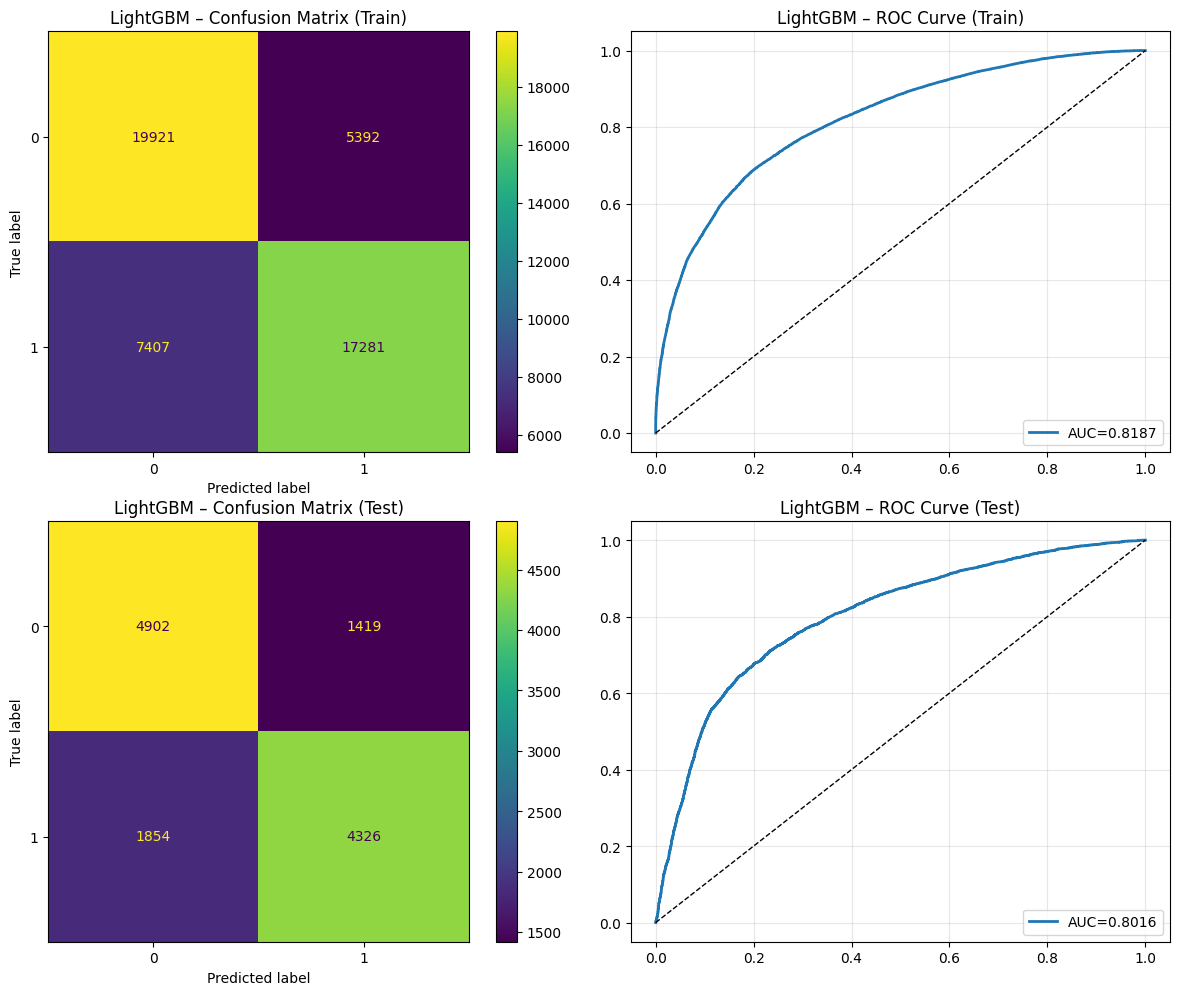

In [14]:
# best_params = {
#     'n_estimators': 233,
#     'learning_rate': 0.019519792757748358,
#     'num_leaves': 41,
#     'max_depth': 15,
#     'subsample': 0.758484089588373,
#     'colsample_bytree': 0.9592852139230149,
#     'random_state': 6580,
#     'verbose' : -1
# }

lgbm_model = LGBMClassifier(verbose=-1)

lgbm_model.fit(x_train_np, y_train_np)

lgbm_results = evaluate_model(
    model=lgbm_model,
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=label_mapping,
    name="LightGBM",
)

lgbm_results;



=== CatBoost ===
Test   Acc: 0.7379, AUC: 0.8013
              precision    recall  f1-score   support

           0     0.7251    0.7760    0.7497      6321
           1     0.7531    0.6990    0.7251      6180

    accuracy                         0.7379     12501
   macro avg     0.7391    0.7375    0.7374     12501
weighted avg     0.7389    0.7379    0.7375     12501

Train  Acc: 0.7529, AUC: 0.8309
              precision    recall  f1-score   support

           0     0.7363    0.7975    0.7657     25313
           1     0.7730    0.7071    0.7386     24688

    accuracy                         0.7529     50001
   macro avg     0.7546    0.7523    0.7521     50001
weighted avg     0.7544    0.7529    0.7523     50001

✅ No significant overfitting



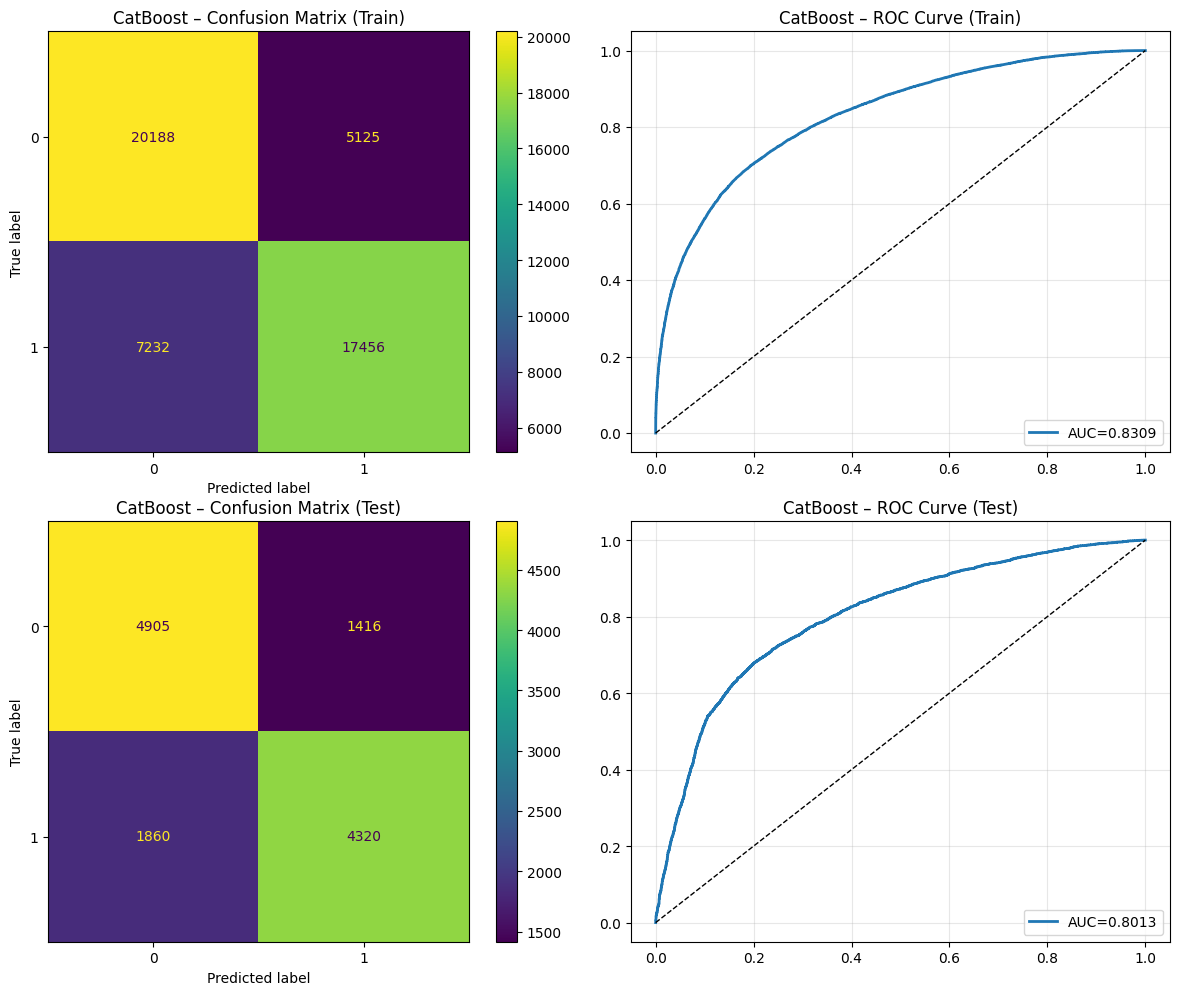

In [15]:
# best_params = {
#     'iterations': 680, 
#     'learning_rate': 0.01040286438048717, 
#     'depth': 9, 
#     'l2_leaf_reg': 0.10424693387826892, 
#     'border_count': 220, 
#     'random_strength': 0.015513247584661348, 
#     'bagging_temperature': 0.2020691195100053, 
#     'random_seed': 7801,
#     'verbose': False
#     }

catb_model = CatBoostClassifier(verbose=False)

catb_model.fit(x_train_np, y_train_np)

catb_results = evaluate_model(
    model=catb_model,
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=label_mapping,
    name="CatBoost",
)

catb_results;


=== Hist Gradient Boosting ===
Test   Acc: 0.7372, AUC: 0.8007
              precision    recall  f1-score   support

           0     0.7262    0.7711    0.7479      6321
           1     0.7500    0.7026    0.7255      6180

    accuracy                         0.7372     12501
   macro avg     0.7381    0.7368    0.7367     12501
weighted avg     0.7380    0.7372    0.7369     12501

Train  Acc: 0.7414, AUC: 0.8151
              precision    recall  f1-score   support

           0     0.7281    0.7806    0.7535     25313
           1     0.7571    0.7011    0.7280     24688

    accuracy                         0.7414     50001
   macro avg     0.7426    0.7409    0.7407     50001
weighted avg     0.7424    0.7414    0.7409     50001

✅ No significant overfitting



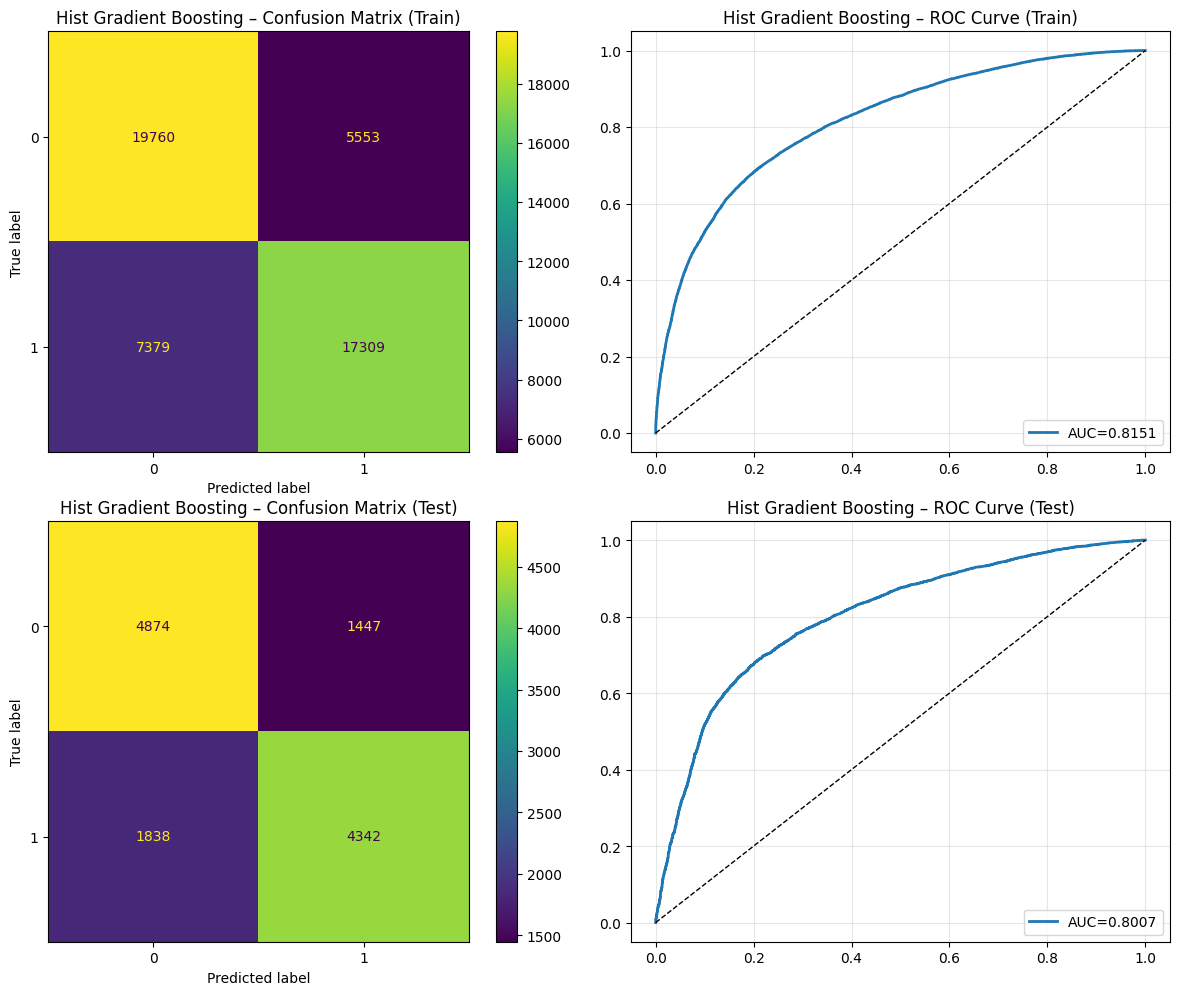

In [16]:
# best_params = {
#     'max_iter': 409, 
#     'learning_rate': 0.01947652219796748, 
#     'max_leaf_nodes': 36, 
#     'min_samples_leaf': 28, 
#     'l2_regularization': 4.313378648780895e-06, 
#     'random_state': 8404
#             }

hgrb_model =  HistGradientBoostingClassifier(random_state=42)

hgrb_model.fit(x_train_np, y_train_np)

hgrb_results = evaluate_model(
    model=hgrb_model,
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=label_mapping,
    name="Hist Gradient Boosting"
)

hgrb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



=== AdaBoost ===
Test   Acc: 0.7320, AUC: 0.7946
              precision    recall  f1-score   support

           0     0.7048    0.8089    0.7532      6321
           1     0.7697    0.6534    0.7068      6180

    accuracy                         0.7320     12501
   macro avg     0.7372    0.7311    0.7300     12501
weighted avg     0.7369    0.7320    0.7303     12501

Train  Acc: 0.7238, AUC: 0.7898
              precision    recall  f1-score   support

           0     0.6968    0.8044    0.7468     25313
           1     0.7618    0.6412    0.6963     24688

    accuracy                         0.7238     50001
   macro avg     0.7293    0.7228    0.7215     50001
weighted avg     0.7289    0.7238    0.7219     50001

✅ No significant overfitting



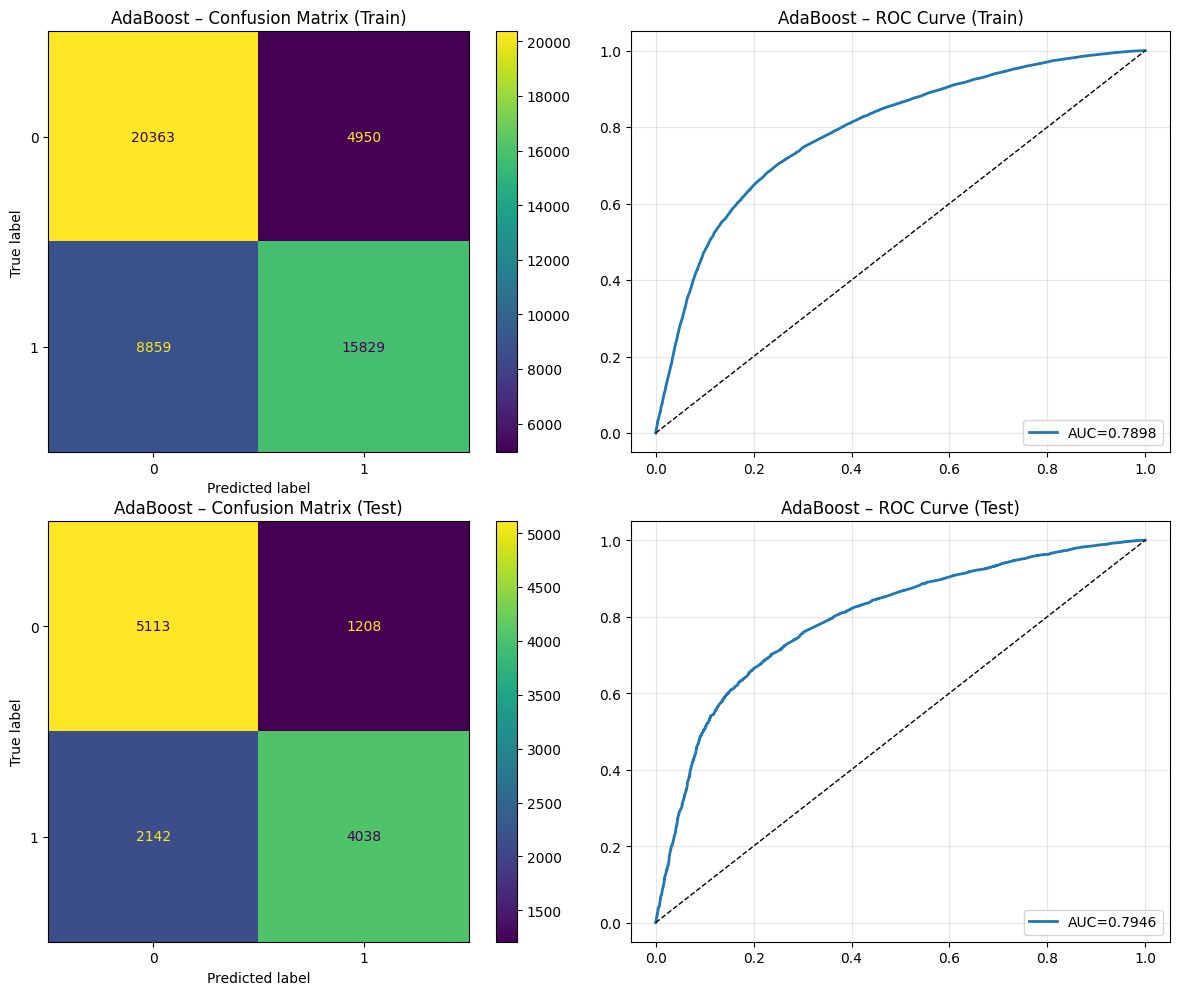

In [17]:
# best_params = {'n_estimators': 478, 'learning_rate': 0.17278746878628695, 'random_state': 5660}

adb_model = AdaBoostClassifier()

adb_model.fit(x_train_np, y_train_np)

adb_results = evaluate_model(
    model=adb_model,
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=label_mapping,
    name="AdaBoost"
)

adb_results;

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py:285: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)



=== TabNet ===
Test   Acc: 0.7382, AUC: 0.8006
              precision    recall  f1-score   support

           0     0.7237    0.7801    0.7508      6321
           1     0.7556    0.6953    0.7242      6180

    accuracy                         0.7382     12501
   macro avg     0.7396    0.7377    0.7375     12501
weighted avg     0.7394    0.7382    0.7377     12501

Train  Acc: 0.7330, AUC: 0.7995
              precision    recall  f1-score   support

           0     0.7176    0.7794    0.7472     25313
           1     0.7519    0.6854    0.7171     24688

    accuracy                         0.7330     50001
   macro avg     0.7347    0.7324    0.7322     50001
weighted avg     0.7345    0.7330    0.7324     50001

✅ No significant overfitting



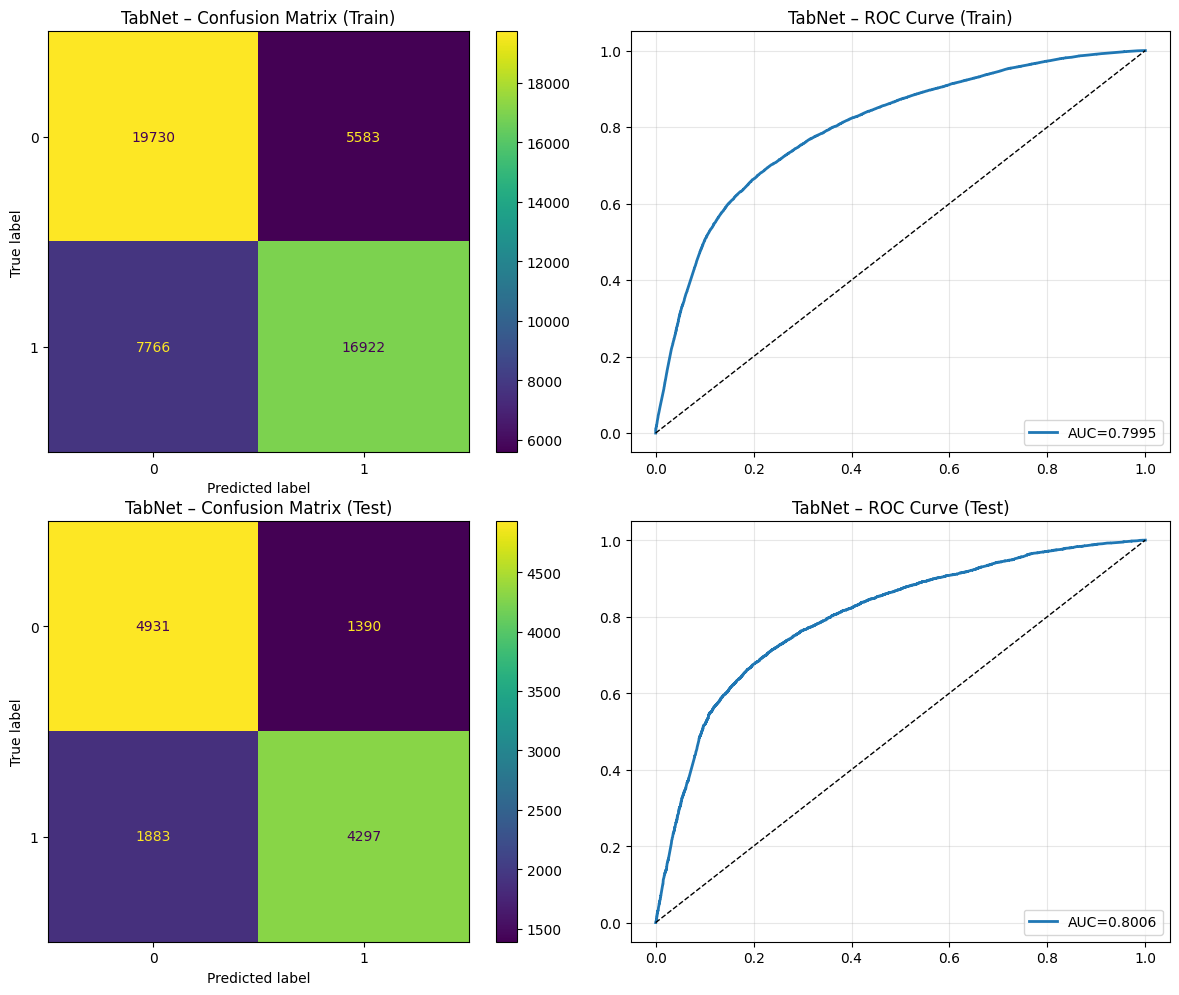

In [18]:
tabnet_model = TabNetClassifier(verbose=0)

tabnet_model.fit(x_train_np, y_train_np)

tabnet_results = evaluate_model(
    model=tabnet_model,
    x_train=x_train_np,
    y_train=y_train_np,
    x_test=x_test_np,
    y_test=y_test_np,
    label_mapping=label_mapping,
    name="TabNet"
)

tabnet_results;

In [ ]:
continuous_indices = list(range(len(numerical_features)))  
categorical_indices = list(range(len(numerical_features), len(transformed_feature_names)))  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[TabTransformer] Epoch 1/10, Loss: 0.5981
[TabTransformer] Epoch 2/10, Loss: 0.5649
[TabTransformer] Epoch 3/10, Loss: 0.5637
[TabTransformer] Epoch 4/10, Loss: 0.5622
[TabTransformer] Epoch 5/10, Loss: 0.5610
[TabTransformer] Epoch 6/10, Loss: 0.5592
[TabTransformer] Epoch 7/10, Loss: 0.5581
[TabTransformer] Epoch 8/10, Loss: 0.5587
[TabTransformer] Epoch 9/10, Loss: 0.5561
[TabTransformer] Epoch 10/10, Loss: 0.5558

=== TabTransformer ===
Test   Acc: 0.7347, AUC: 0.7956
              precision    recall  f1-score   support

         0.0     0.7081    0.8084    0.7550      6321
         1.0     0.7709    0.6592    0.7107      6180

    accuracy                         0.7347     12501
   macro avg     0.7395    0.7338    0.7328     12501
weighted avg     0.7392    0.7347    0.7331     12501

Train  Acc: 0.7260, AUC: 0.7912
              precision    recall  f1-score   support

         0.0     0.6995    0.8043    0.7483     25313
         1.0     0.7629    0.6458    0.6995     24688



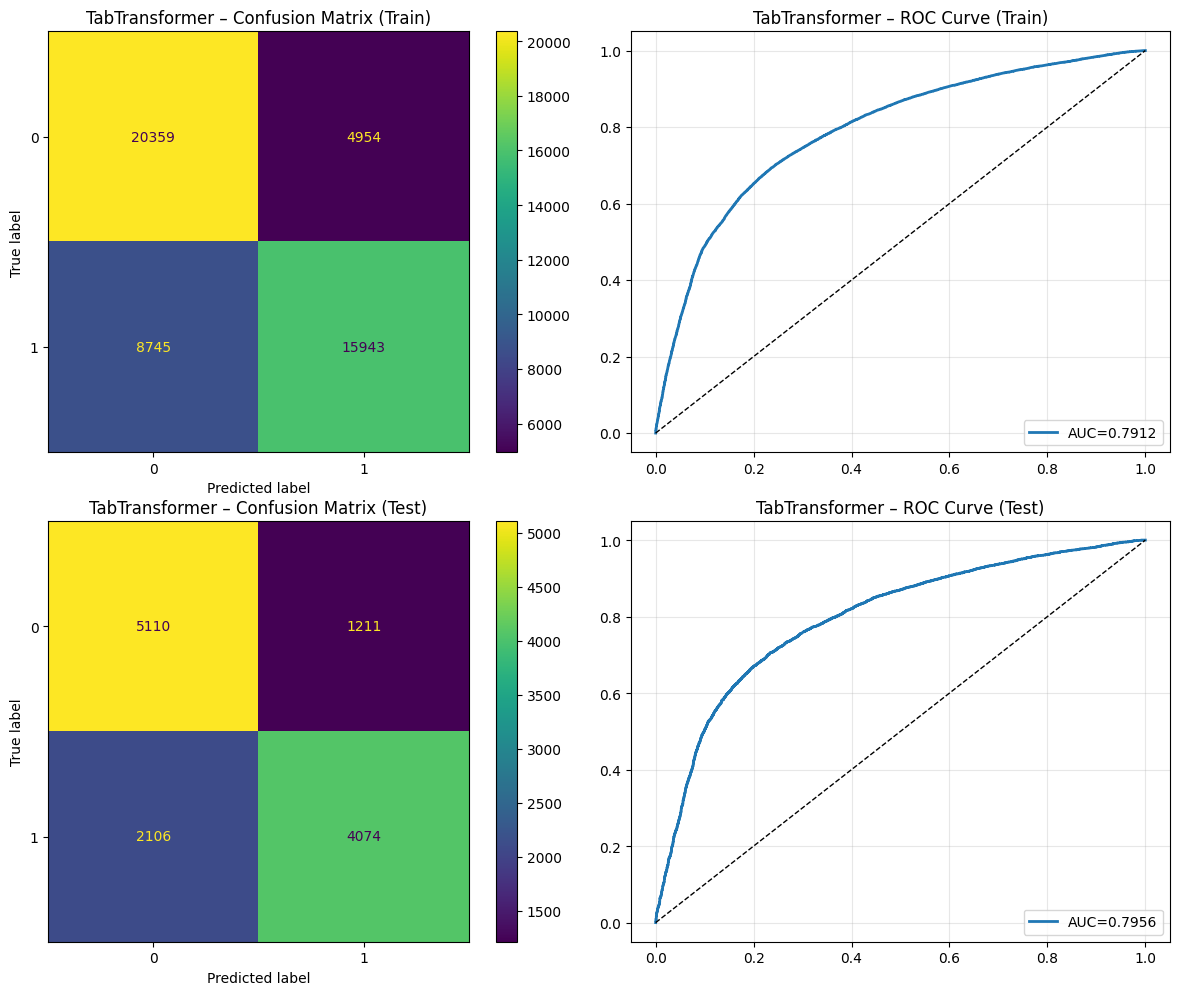

In [20]:
tabtf_model = TabTransformer(
    categories = (3, 3, 2, 2, 2, 2), 
    num_continuous = len(continuous_indices),
    dim = 32,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.1,
    ff_dropout = 0.1,
    mlp_hidden_mults = (4, 2),
    mlp_act = nn.ReLU(),
    continuous_mean_std = None
).to(device)

tabtf_wrapper = PyTorchClassifier(
    model=tabtf_model,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    categorical_indices=list(range(len(numerical_features), len(transformed_feature_names))),
    continuous_indices=list(range(len(numerical_features)))
)

tabtf_results = evaluate_model(
    model=tabtf_model,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='TabTransformer',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices,
)


tabtf_results;

[FT-Transformer] Epoch 1/10, Loss: 0.5600
[FT-Transformer] Epoch 2/10, Loss: 0.5537
[FT-Transformer] Epoch 3/10, Loss: 0.5522
[FT-Transformer] Epoch 4/10, Loss: 0.5514
[FT-Transformer] Epoch 5/10, Loss: 0.5515
[FT-Transformer] Epoch 6/10, Loss: 0.5506
[FT-Transformer] Epoch 7/10, Loss: 0.5495
[FT-Transformer] Epoch 8/10, Loss: 0.5488
[FT-Transformer] Epoch 9/10, Loss: 0.5494
[FT-Transformer] Epoch 10/10, Loss: 0.5485

=== FT-Transformer ===
Test   Acc: 0.7387, AUC: 0.8018
              precision    recall  f1-score   support

         0.0     0.7263    0.7755    0.7501      6321
         1.0     0.7533    0.7011    0.7263      6180

    accuracy                         0.7387     12501
   macro avg     0.7398    0.7383    0.7382     12501
weighted avg     0.7397    0.7387    0.7383     12501

Train  Acc: 0.7306, AUC: 0.7982
              precision    recall  f1-score   support

         0.0     0.7176    0.7716    0.7436     25313
         1.0     0.7462    0.6886    0.7162     24688



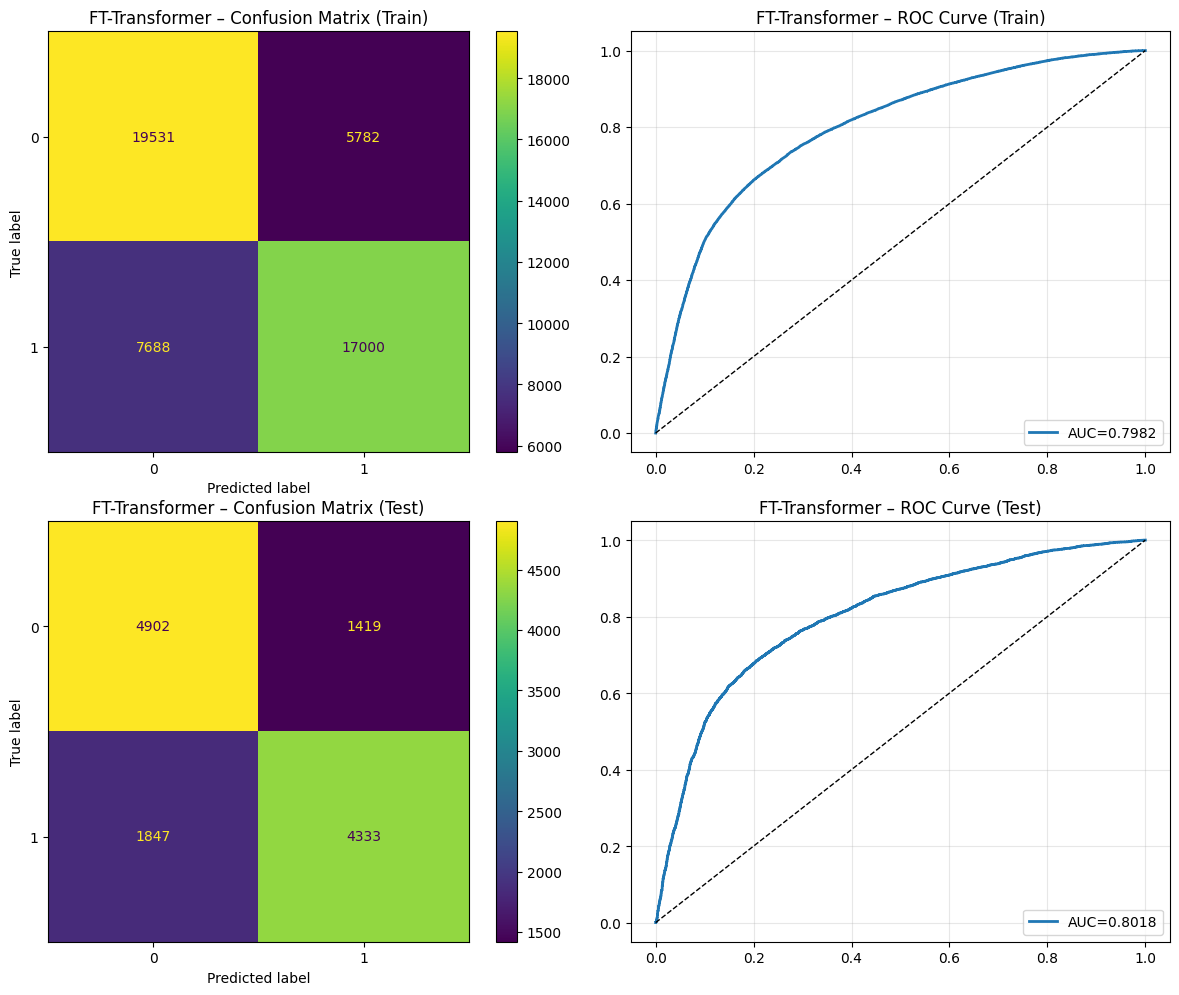

In [23]:
fttf_model = FTTransformer(
    categories = (3, 3, 2, 2, 2, 2), 
    num_continuous = len(continuous_indices),
    dim = 32,
    dim_out = 1,
    depth = 6,
    heads = 8,
    attn_dropout = 0.1,
    ff_dropout = 0.1
).to(device)

fttf_wrapper = PyTorchClassifier(
    model=fttf_model,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    categorical_indices=list(range(len(numerical_features), len(transformed_feature_names))),
    continuous_indices=list(range(len(numerical_features)))
)

ftttf_results = evaluate_model(
    model=fttf_model,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='FT-Transformer',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices,
)


ftttf_results;


In [24]:
base_models_ml = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model)
]

base_models_dl = [
    ('tabnet', tabnet_model),
    ('tabtf', tabtf_wrapper),
    ('fttf', fttf_wrapper)
]

base_models_el = [
    ('lgbm', lgbm_model),
    ('cat', catb_model),
    ('hgrb', hgrb_model),
    ('tabnet', tabnet_model),
    ('tabtf',tabtf_wrapper),
    ('fttf', fttf_wrapper)
]

In [25]:
meta_model = adb_model

In [26]:
stacking_model_ml = StackingClassifier(estimators=base_models_ml,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_dl = StackingClassifier(estimators=base_models_dl,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

stacking_model_el = StackingClassifier(estimators=base_models_el,
                                    final_estimator=meta_model,
                                    cv=5,
                                    passthrough=True)

In [27]:
stacking_model_ml.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x75334ee52140>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


=== Stacking ML Model ===
Test   Acc: 0.7385, AUC: 0.7999
              precision    recall  f1-score   support

           0     0.7138    0.8060    0.7571      6321
           1     0.7714    0.6694    0.7168      6180

    accuracy                         0.7385     12501
   macro avg     0.7426    0.7377    0.7370     12501
weighted avg     0.7423    0.7385    0.7372     12501

Train  Acc: 0.7487, AUC: 0.8163
              precision    recall  f1-score   support

           0     0.7207    0.8223    0.7682     25313
           1     0.7871    0.6732    0.7257     24688

    accuracy                         0.7487     50001
   macro avg     0.7539    0.7478    0.7469     50001
weighted avg     0.7535    0.7487    0.7472     50001

✅ No significant overfitting



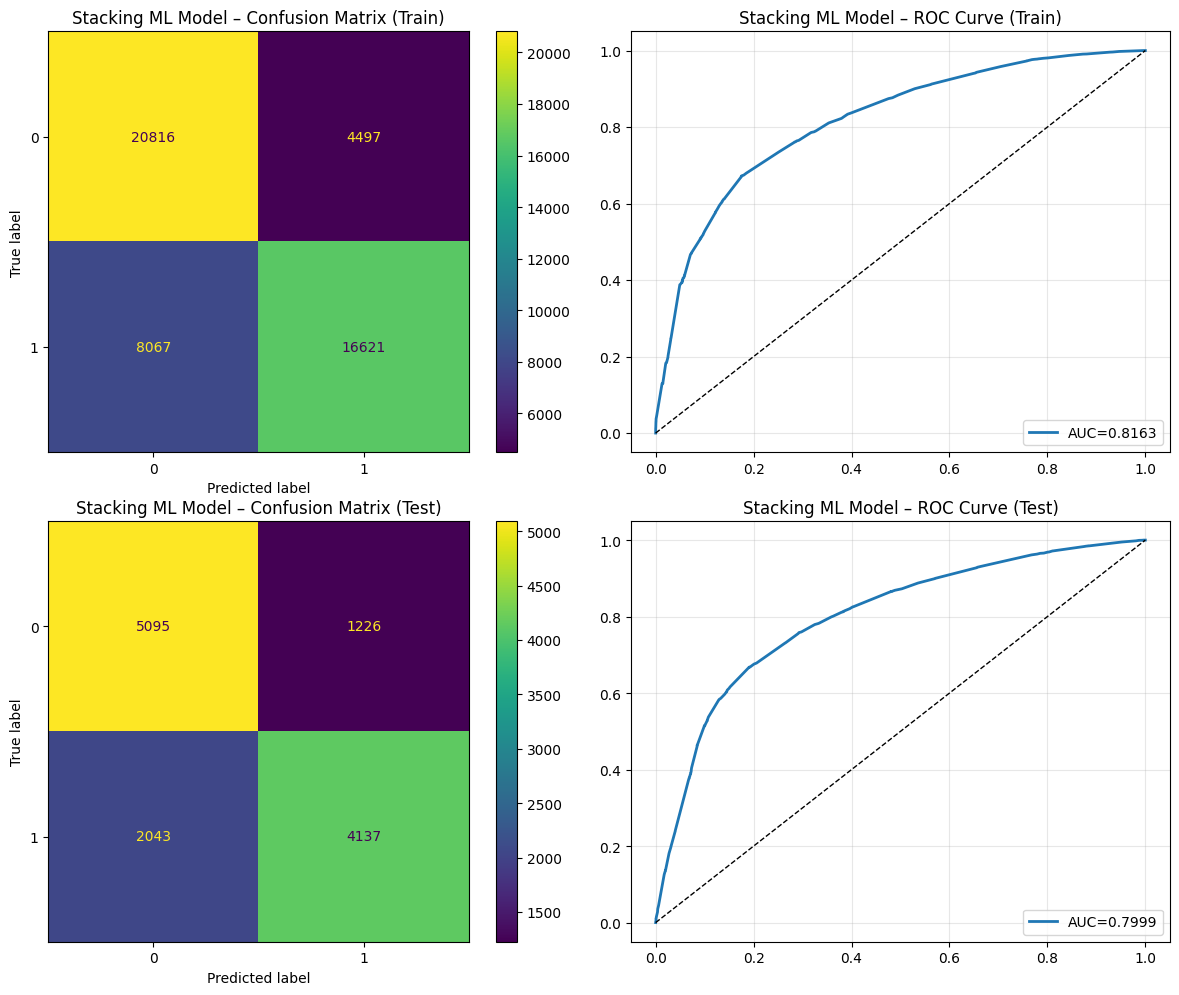

In [28]:
stacking_model_ml_results = evaluate_model(
    model=stacking_model_ml,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='Stacking ML Model',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices
)

stacking_model_ml_results;

In [29]:
stacking_model_dl.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.5554
[Wrapper] Epoch 2/10, Loss: 0.5548
[Wrapper] Epoch 3/10, Loss: 0.5536
[Wrapper] Epoch 4/10, Loss: 0.5531
[Wrapper] Epoch 5/10, Loss: 0.5537
[Wrapper] Epoch 6/10, Loss: 0.5522
[Wrapper] Epoch 7/10, Loss: 0.5521
[Wrapper] Epoch 8/10, Loss: 0.5514
[Wrapper] Epoch 9/10, Loss: 0.5512
[Wrapper] Epoch 10/10, Loss: 0.5501
[Wrapper] Epoch 1/10, Loss: 0.5478
[Wrapper] Epoch 2/10, Loss: 0.5480
[Wrapper] Epoch 3/10, Loss: 0.5476
[Wrapper] Epoch 4/10, Loss: 0.5477
[Wrapper] Epoch 5/10, Loss: 0.5472
[Wrapper] Epoch 6/10, Loss: 0.5467
[Wrapper] Epoch 7/10, Loss: 0.5465
[Wrapper] Epoch 8/10, Loss: 0.5465
[Wrapper] Epoch 9/10, Loss: 0.5462
[Wrapper] Epoch 10/10, Loss: 0.5458


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.5549
[Wrapper] Epoch 2/10, Loss: 0.5544
[Wrapper] Epoch 3/10, Loss: 0.5539
[Wrapper] Epoch 4/10, Loss: 0.5527
[Wrapper] Epoch 5/10, Loss: 0.5527
[Wrapper] Epoch 6/10, Loss: 0.5508
[Wrapper] Epoch 7/10, Loss: 0.5523
[Wrapper] Epoch 8/10, Loss: 0.5505
[Wrapper] Epoch 9/10, Loss: 0.5494
[Wrapper] Epoch 10/10, Loss: 0.5493
[Wrapper] Epoch 1/10, Loss: 0.5546
[Wrapper] Epoch 2/10, Loss: 0.5527
[Wrapper] Epoch 3/10, Loss: 0.5527
[Wrapper] Epoch 4/10, Loss: 0.5517
[Wrapper] Epoch 5/10, Loss: 0.5521
[Wrapper] Epoch 6/10, Loss: 0.5503
[Wrapper] Epoch 7/10, Loss: 0.5513
[Wrapper] Epoch 8/10, Loss: 0.5494
[Wrapper] Epoch 9/10, Loss: 0.5485
[Wrapper] Epoch 10/10, Loss: 0.5486
[Wrapper] Epoch 1/10, Loss: 0.5572
[Wrapper] Epoch 2/10, Loss: 0.5561
[Wrapper] Epoch 3/10, Loss: 0.5551
[Wrapper] Epoch 4/10, Loss: 0.5551
[Wrapper] Epoch 5/10, Loss: 0.5710
[Wrapper] Epoch 6/10, Loss: 0.5699
[Wrapper] Epoch 7/10, Loss: 0.5632
[Wrapper] Epoch 8/10, Loss: 0.5614
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lambda_sparse=0.001,
                                                 seed=0,
                                                 clip_value=1,
                                                 verbose=0,
                                                 optimizer_fn=<class 'torch.optim.adam.Adam'>,
                                                 optimizer_params={'lr': 0.02},
                                                 scheduler_fn=None,
                                                 scheduler_params={},...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


=== Stacking DL Model ===
Test   Acc: 0.7391, AUC: 0.8009
              precision    recall  f1-score   support

           0     0.7317    0.7643    0.7477      6321
           1     0.7474    0.7134    0.7300      6180

    accuracy                         0.7391     12501
   macro avg     0.7396    0.7389    0.7388     12501
weighted avg     0.7395    0.7391    0.7389     12501

Train  Acc: 0.7336, AUC: 0.8006
              precision    recall  f1-score   support

           0     0.7248    0.7636    0.7437     25313
           1     0.7436    0.7028    0.7226     24688

    accuracy                         0.7336     50001
   macro avg     0.7342    0.7332    0.7332     50001
weighted avg     0.7341    0.7336    0.7333     50001

✅ No significant overfitting



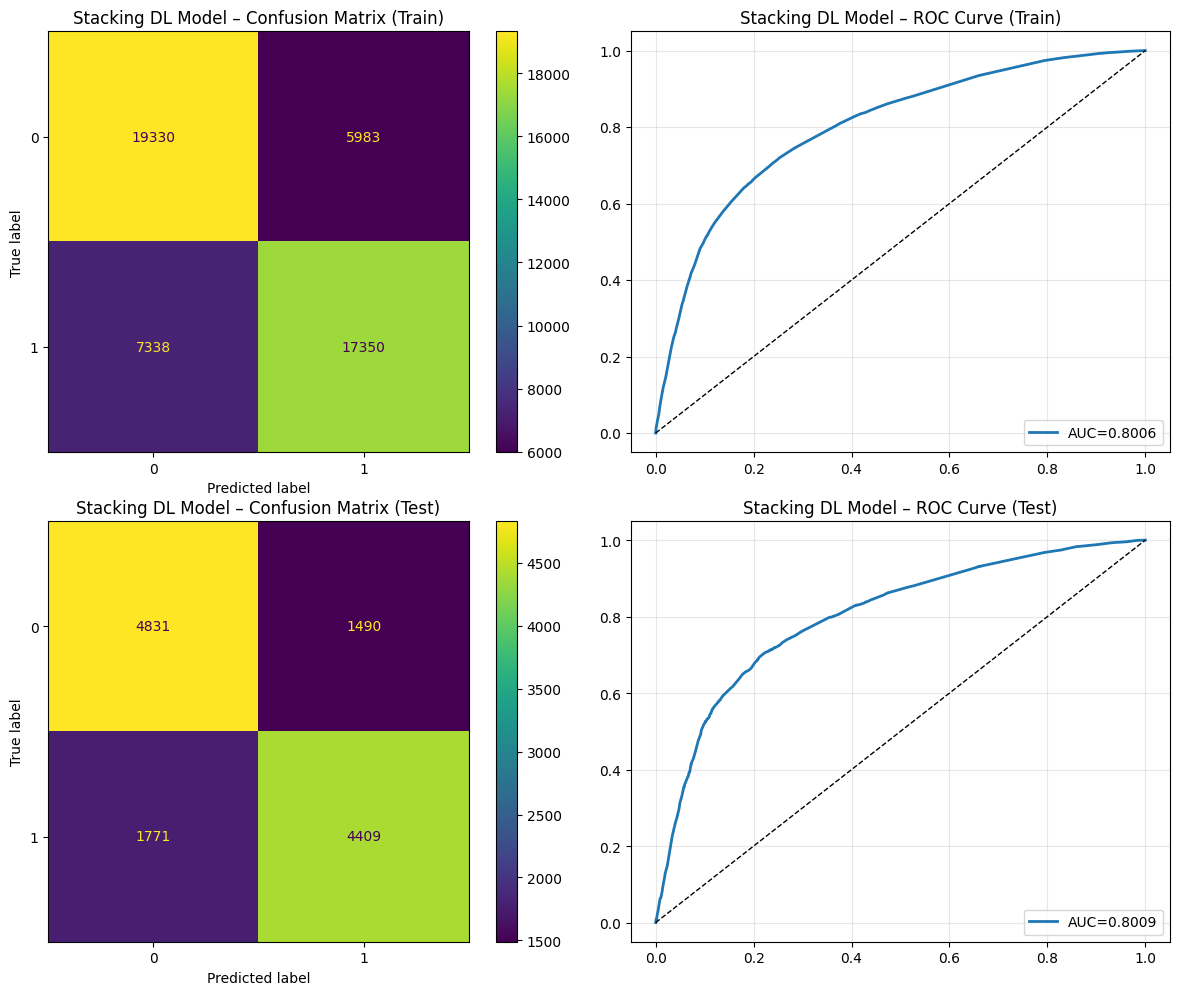

In [30]:
stacking_model_dl_results = evaluate_model(
    model=stacking_model_dl,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='Stacking DL Model',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices
)


stacking_model_dl_results;


In [31]:
stacking_model_el.fit(x_train_np, y_train_np)

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


[Wrapper] Epoch 1/10, Loss: 0.5554
[Wrapper] Epoch 2/10, Loss: 0.5548
[Wrapper] Epoch 3/10, Loss: 0.5536
[Wrapper] Epoch 4/10, Loss: 0.5531
[Wrapper] Epoch 5/10, Loss: 0.5537
[Wrapper] Epoch 6/10, Loss: 0.5522
[Wrapper] Epoch 7/10, Loss: 0.5521
[Wrapper] Epoch 8/10, Loss: 0.5514
[Wrapper] Epoch 9/10, Loss: 0.5512
[Wrapper] Epoch 10/10, Loss: 0.5501
[Wrapper] Epoch 1/10, Loss: 0.5478
[Wrapper] Epoch 2/10, Loss: 0.5480
[Wrapper] Epoch 3/10, Loss: 0.5476
[Wrapper] Epoch 4/10, Loss: 0.5477
[Wrapper] Epoch 5/10, Loss: 0.5472
[Wrapper] Epoch 6/10, Loss: 0.5467
[Wrapper] Epoch 7/10, Loss: 0.5465
[Wrapper] Epoch 8/10, Loss: 0.5465
[Wrapper] Epoch 9/10, Loss: 0.5462
[Wrapper] Epoch 10/10, Loss: 0.5458


/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)
/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/sit

[Wrapper] Epoch 1/10, Loss: 0.5549
[Wrapper] Epoch 2/10, Loss: 0.5544
[Wrapper] Epoch 3/10, Loss: 0.5539
[Wrapper] Epoch 4/10, Loss: 0.5527
[Wrapper] Epoch 5/10, Loss: 0.5527
[Wrapper] Epoch 6/10, Loss: 0.5508
[Wrapper] Epoch 7/10, Loss: 0.5523
[Wrapper] Epoch 8/10, Loss: 0.5505
[Wrapper] Epoch 9/10, Loss: 0.5494
[Wrapper] Epoch 10/10, Loss: 0.5493
[Wrapper] Epoch 1/10, Loss: 0.5546
[Wrapper] Epoch 2/10, Loss: 0.5527
[Wrapper] Epoch 3/10, Loss: 0.5527
[Wrapper] Epoch 4/10, Loss: 0.5517
[Wrapper] Epoch 5/10, Loss: 0.5521
[Wrapper] Epoch 6/10, Loss: 0.5503
[Wrapper] Epoch 7/10, Loss: 0.5513
[Wrapper] Epoch 8/10, Loss: 0.5494
[Wrapper] Epoch 9/10, Loss: 0.5485
[Wrapper] Epoch 10/10, Loss: 0.5486
[Wrapper] Epoch 1/10, Loss: 0.5572
[Wrapper] Epoch 2/10, Loss: 0.5561
[Wrapper] Epoch 3/10, Loss: 0.5551
[Wrapper] Epoch 4/10, Loss: 0.5551
[Wrapper] Epoch 5/10, Loss: 0.5710
[Wrapper] Epoch 6/10, Loss: 0.5699
[Wrapper] Epoch 7/10, Loss: 0.5632
[Wrapper] Epoch 8/10, Loss: 0.5614
[Wrapper] Epoch 9/

/home/qul/Developments/College/final_project/.venv_el/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


StackingClassifier(cv=5,
                   estimators=[('lgbm', LGBMClassifier(verbose=-1)),
                               ('cat',
                                <catboost.core.CatBoostClassifier object at 0x75334ee52140>),
                               ('hgrb',
                                HistGradientBoostingClassifier(random_state=42)),
                               ('tabnet',
                                TabNetClassifier(n_d=8,
                                                 n_a=8,
                                                 n_steps=3,
                                                 gamma=1.3,
                                                 cat_idxs=[],
                                                 cat_dims=[],
                                                 cat_emb_dim=[],
                                                 n_independent=2,
                                                 n_shared=2,
                                                 epsilon=1e-15,
                                                 momentum=0.02,
                                                 lam...
            (4): Linear(in_features=128, out_features=32, bias=True)
          )
          (act): Tanh()
          (norm): RMSNorm()
          (dropout): Dropout(p=0.0, inplace=False)
          (residual_transform): Identity()
        )
      )
    )
  )
  (to_logits): Sequential(
    (0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)))],
                   final_estimator=AdaBoostClassifier(), passthrough=True)


=== Stacking Hybird Ensemble Model ===
Test   Acc: 0.7389, AUC: 0.8005
              precision    recall  f1-score   support

           0     0.7309    0.7654    0.7478      6321
           1     0.7479    0.7118    0.7294      6180

    accuracy                         0.7389     12501
   macro avg     0.7394    0.7386    0.7386     12501
weighted avg     0.7393    0.7389    0.7387     12501

Train  Acc: 0.7338, AUC: 0.8091
              precision    recall  f1-score   support

           0     0.7245    0.7651    0.7442     25313
           1     0.7444    0.7017    0.7224     24688

    accuracy                         0.7338     50001
   macro avg     0.7345    0.7334    0.7333     50001
weighted avg     0.7343    0.7338    0.7335     50001

✅ No significant overfitting



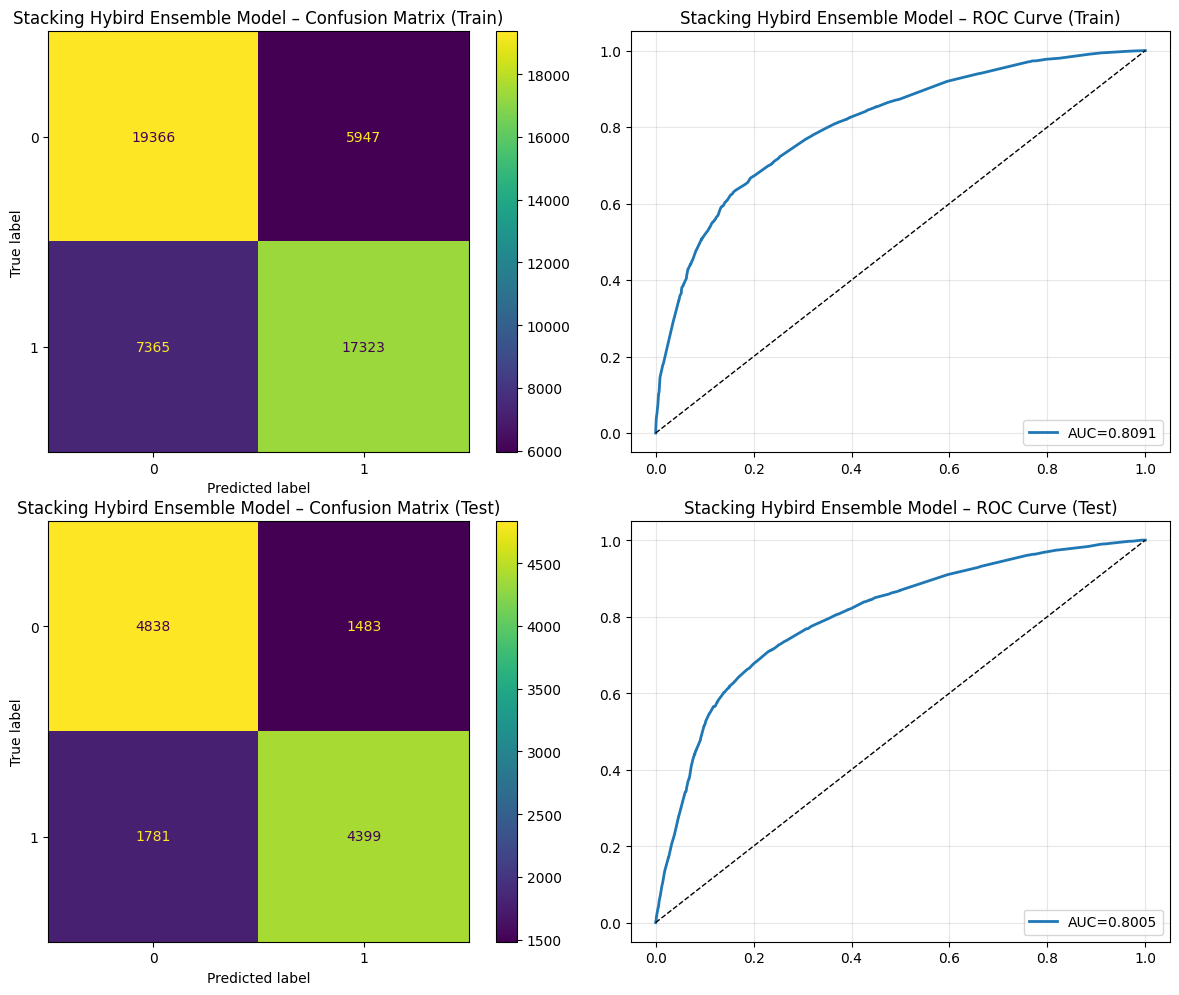

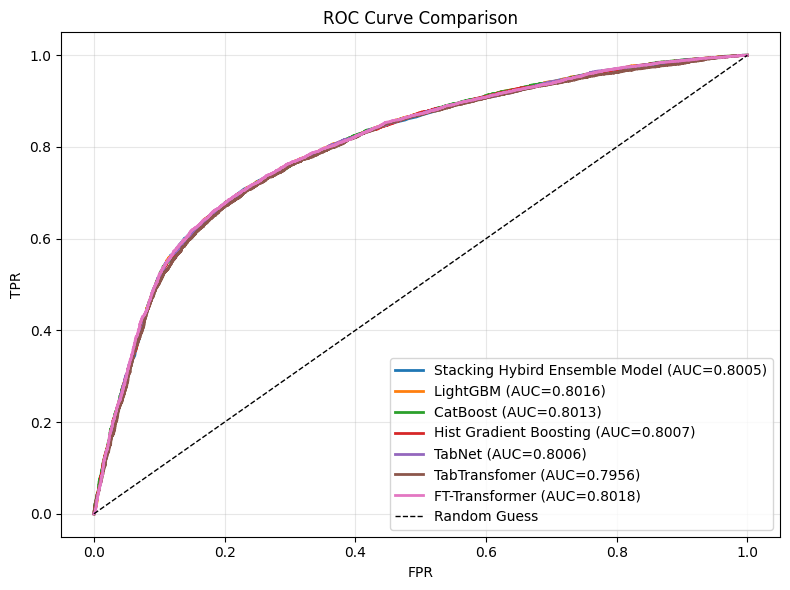

In [32]:
stacking_model_el_results = evaluate_model(
    model=stacking_model_el,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='Stacking Hybird Ensemble Model',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices,
    comparison_models={'LightGBM': lgbm_model, 'CatBoost': catb_model, 'Hist Gradient Boosting': hgrb_model, 
                    'TabNet':tabnet_model, 'TabTransfomer': tabtf_model, 'FT-Transformer': fttf_model}
)


stacking_model_el_results;


=== Stacking Hybird Ensemble Model ===
Test   Acc: 0.7389, AUC: 0.8005
              precision    recall  f1-score   support

           0     0.7309    0.7654    0.7478      6321
           1     0.7479    0.7118    0.7294      6180

    accuracy                         0.7389     12501
   macro avg     0.7394    0.7386    0.7386     12501
weighted avg     0.7393    0.7389    0.7387     12501

Train  Acc: 0.7338, AUC: 0.8091
              precision    recall  f1-score   support

           0     0.7245    0.7651    0.7442     25313
           1     0.7444    0.7017    0.7224     24688

    accuracy                         0.7338     50001
   macro avg     0.7345    0.7334    0.7333     50001
weighted avg     0.7343    0.7338    0.7335     50001

✅ No significant overfitting



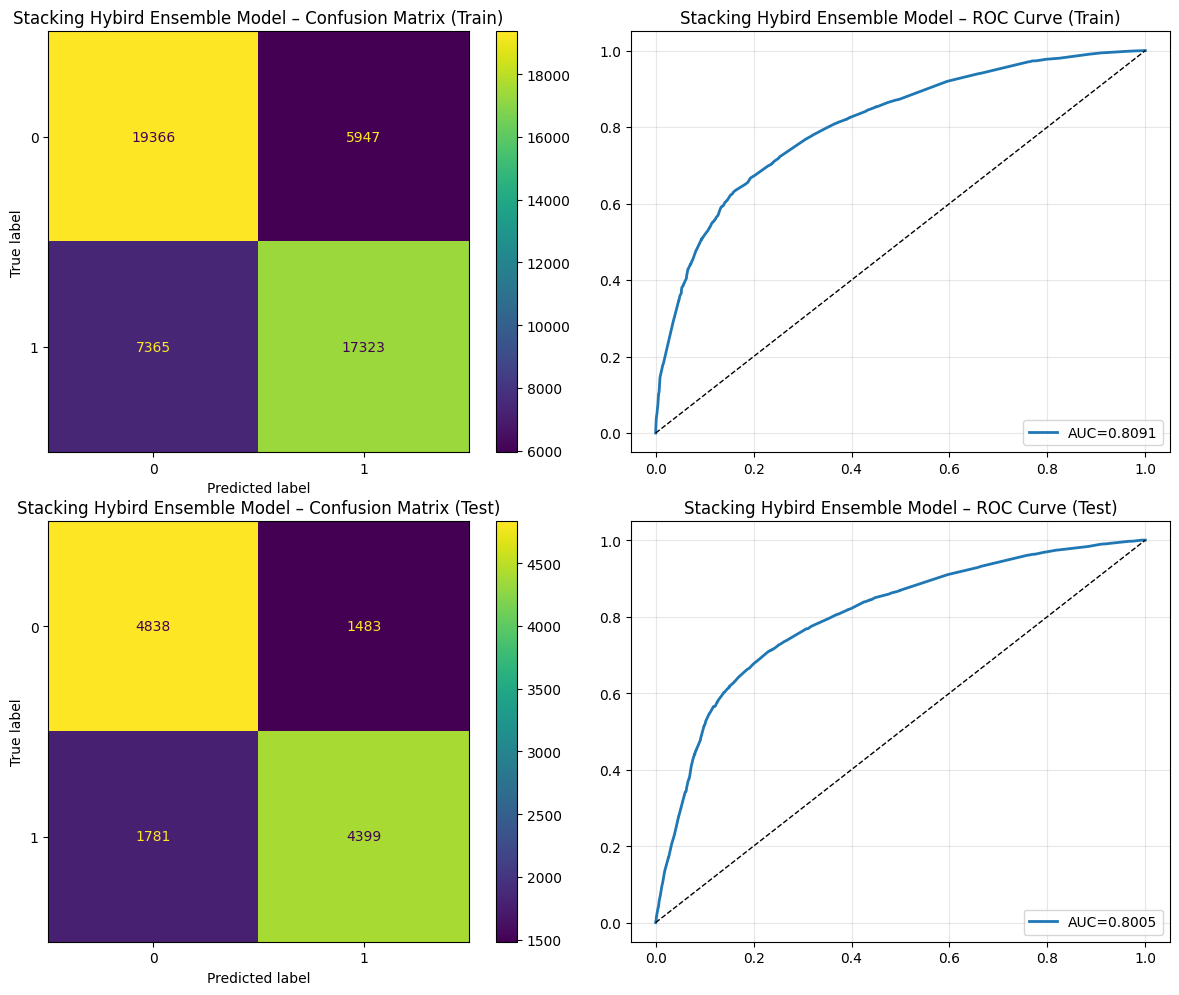

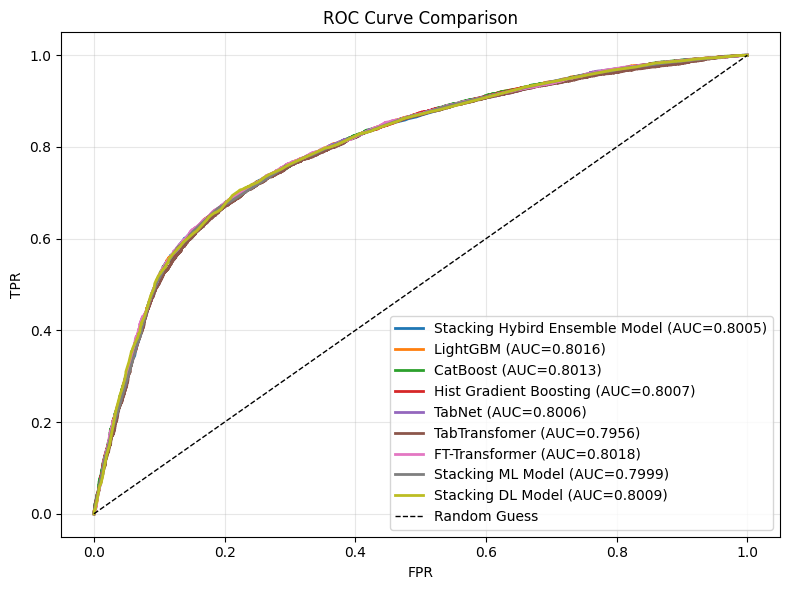

In [33]:
stacking_model_el_results = evaluate_model(
    model=stacking_model_el,
    x_train=x_train_np, y_train=y_train_np,
    x_test =x_test_np,  y_test =y_test_np,
    name='Stacking Hybird Ensemble Model',
    label_mapping=label_mapping,
    cat_indices=categorical_indices,
    cont_indices=continuous_indices,
    comparison_models={'LightGBM': lgbm_model, 'CatBoost': catb_model, 'Hist Gradient Boosting': hgrb_model, 
                    'TabNet':tabnet_model, 'TabTransfomer': tabtf_model, 'FT-Transformer': fttf_model, 
                    'Stacking ML Model': stacking_model_ml, 'Stacking DL Model':stacking_model_dl}
)


stacking_model_el_results;

In [ ]:
# import numpy as np
# from scipy.stats import pearsonr

# # Misal, prediksi probabilitas dari base model disimpan dalam dictionary
# # Prediksi base model harus berupa array 1 dimensi (misalnya, probabilitas kelas positif)
# preds_lgbm = lgbm_model.predict_proba(x_test_np)[:, 1]
# preds_cat = catb_model.predict_proba(x_test_np)[:, 1]
# preds_hgrb = hgrb_model.predict_proba(x_test_np)[:, 1]
# preds_tabnet = tabnet_model.predict_proba(x_test_np)[:, 1]

# # Menyimpan semua prediksi di dalam array
# all_preds = np.vstack([preds_lgbm, preds_cat, preds_hgrb, preds_tabnet])

# # Menghitung korelasi antar model
# n_models = all_preds.shape[0]
# for i in range(n_models):
#     for j in range(i+1, n_models):
#         corr_coef, _ = pearsonr(all_preds[i], all_preds[j])
#         print(f"Korelasi antara model {i} dan model {j}: {corr_coef:.3f}")


In [ ]:
# numerical_features = ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 'map', 'pulse_pressure']

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ],
#     remainder='passthrough' 
# )

# pipeline = Pipeline(steps=[
#     ('preprocessor', preprocessor),
#     ('classifier', stacking_model)
# ])

# pipeline.fit(X_train, y_train)

# with open("pkl/ml_ensemble_model.pkl", "wb") as f:
#     pickle.dump(pipeline, f)

# print("Pipeline telah disimpan dalam file 'ml_ensemble_model_v2.pkl'.")

In [ ]:
# with open('pkl/ml_ensemble_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)

# # Lakukan prediksi menggunakan CPU
# y_pred = loaded_model.predict(X_test)

# # Menghitung dan menampilkan accuracy score
# acc = accuracy_score(y_test, y_pred)
# print("Akurasi model:", acc)

In [ ]:
# data_new = {
#     'age':       [30, 35, 40, 45, 50, 60, 65, 70, 55, 68],   
#     'height':    [175, 180, 170, 165, 160, 158, 155, 150, 165, 160], 
#     'weight':    [68, 75, 72, 80, 85, 90, 95, 100, 78, 82], 
#     'systolic':  [110, 115, 120, 125, 130, 140, 150, 160, 115, 135],  
#     'diastolic': [70, 75, 80, 85, 90, 95, 100, 105, 75, 88],         
#     'gender':       [0, 0, 1, 0, 1, 1, 1, 1, 0, 1], # gender: 0 untuk nilai asli 1, 1 untuk nilai asli 2
#     'cholesterol':  [0, 0, 1, 1, 2, 2, 2, 2, 0, 2], # cholesterol: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'gluc':         [0, 0, 1, 1, 1, 2, 2, 2, 0, 2], # gluc: 0 untuk nilai asli 1, 1 untuk nilai asli 2, 2 untuk nilai asli 3
#     'smoke':        [0, 0, 0, 0, 1, 1, 1, 1, 0, 1],
#     'alco':         [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
#     'active':       [1, 1, 1, 1, 0, 0, 0, 0, 1, 0]
# }

# new_df = pd.DataFrame(data_new)

# valid_gender      = new_df['gender'].isin([0, 1])
# valid_cholesterol = new_df['cholesterol'].isin([0, 1, 2])
# valid_gluc        = new_df['gluc'].isin([0, 1, 2])
# valid_smoke       = new_df['smoke'].isin([0, 1])
# valid_alco        = new_df['alco'].isin([0, 1])
# valid_active      = new_df['active'].isin([0, 1])

# if not (valid_gender.all() and valid_cholesterol.all() and valid_gluc.all() and 
#         valid_smoke.all() and valid_alco.all() and valid_active.all()):
#     raise ValueError("Terdapat nilai kategori yang tidak valid pada input data.")

# new_df["bmi"] = round(new_df["weight"] / ((new_df["height"] / 100) ** 2), 2)
# new_df["map"] = round((new_df["systolic"] + 2 * new_df["diastolic"]) / 3, 2)
# new_df["pulse_pressure"] = new_df["systolic"] - new_df["diastolic"]

# expected_order = [
#     'age', 'height', 'weight', 'systolic', 'diastolic', 
#     'bmi', 'map', 'pulse_pressure',
#     'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active'
# ]
# new_df = new_df[expected_order]

# with open("pkl/ml_ensemble_model.pkl", "rb") as f:
#     pipeline = pickle.load(f)

# predictions = pipeline.predict(new_df)

# print("Input Data Baru (setelah pembuatan fitur turunan dan validasi):")
# print(new_df)
# print("\nHasil Prediksi untuk 10 contoh data:")
# print("Prediksi status cardio untuk data baru:", predictions)


In [ ]:
# stacking_results = evaluate_model(stacking_model, x_train_np, y_train, x_test_np, y_test, "Stacking Ensemble Classifier")
# stacking_results;

In [ ]:
# results = [lgbm_results, xgb_results, catb_results, 
#         snb_results, grb_results, hgrb_results, stacking_results
#         ]

# create_summary_table(results)